In [1]:
#import the neccesary libraries
from datetime import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
import time
import matplotlib as mpl
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import re
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from fbprophet import Prophet
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False
pd.set_option('display.max_columns', None)

/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
Db_host='127.0.0.1'
Db_name='postgres'
Db_user='postgres'
Db_pass='Brunei42i'

In [3]:
conn = psycopg2.connect(host=Db_host, dbname=Db_name, user=Db_user,password=Db_pass)
conn.set_session(autocommit=True)
cur = conn.cursor()

In [4]:
parallel=pd.read_sql_query("SELECT * FROM parallel_trades",conn)
parallel.head()

/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,chain,collectionaddress,collectionname,exchange,logindex,maker,price,quotecurrency,side,taker,thumbnailurl,timestamp,tokenid,tx,txindex,date,id
0,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,514,0x661d0eaf85b3af039aa457473e5d448b2ce38ce6,0.0013,ETH,buy,0xb9dfffe3dd0956455ebba025bc3f6de4ca6bed87,https://storage.googleapis.com/parsec-nft-stor...,1649804649,10545.0,0xcc40b548c1d454b42c0d8a06d8adb23ffb514b63fa2d...,210.0,2022-04-12,5111
1,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,179,0x4050fb6fac4a6dbf61b63d6cba8e344a2ee9057d,0.0200,ETH,buy,0xb587cbaec20ef78296e1d3b105b5b6aa4ff0c3b4,https://storage.googleapis.com/parsec-nft-stor...,1649804054,10566.0,0xc9f1d2dd0b0afc70f254691ea119d1936288bfc261ae...,72.0,2022-04-12,5947
2,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,99,0x2f02c4e2da54a0df1f40dfec773ded5125dc28bf,0.0100,ETH,buy,0x215e14543142af17e2cb0ef08db5c126776d59f4,https://storage.googleapis.com/parsec-nft-stor...,1649795459,10568.0,0xd8bc48264001571f79164bfa5c409d5eedecd56ceff6...,64.0,2022-04-12,14484
3,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,269,0x91b2642e5317074f25a47dc2b65c280e9b3427a0,0.0380,ETH,sell,0xbc0139b7b925cd3aaf818880ff45ed15b077e111,https://storage.googleapis.com/parsec-nft-stor...,1649795052,10503.0,0x1cc4302565f7c9c1194d601e68e84389dbd88ac856d2...,127.0,2022-04-12,14655
4,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,282,0x6c9af2c7b46b8c94061088a1f3bbf9b6651fc34c,0.0010,ETH,buy,0x6917b4f314e3e1e34750432f3c4fa6d6ebd878e0,https://storage.googleapis.com/parsec-nft-stor...,1649793126,10556.0,0x9ac3ba9439a650835fe905fd55571dafb14e5e5bc81d...,138.0,2022-04-12,16319


In [5]:
from datetime import datetime
parallel['date']=parallel['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [6]:
parallel['date']=pd.to_datetime(parallel['date'])
parallel=parallel[parallel['date']>'2021-08-01']

In [7]:
parallel=parallel[parallel['price']>=0]

In [8]:
df=parallel.groupby([pd.Grouper(key='date', freq='d'),  'collectionname']).agg({
    'maker':['nunique'],
    'taker':['nunique'],
    'thumbnailurl':['nunique'],
    'tx':['nunique'],
    'price':['min','mean','median']})

In [9]:
len(df)

255

In [10]:
def flatten_columns(df, prefix=''):
    columns = []
    for cs in df:
        if type(cs) is str:
            cs = re.sub('\W+','_', cs)
        elif type(cs) is not list and type(cs) is not tuple:
            print (cs)
            cs = str(cs)
        else:
            cs = re.sub("\W+", "", "".join([str(c) for c in cs]))
        cs = cs.lower()
        if prefix:
            cs = prefix + '' + cs
        cs = re.sub('\+$', '', cs)
        columns.append(cs)
    return columns

In [11]:
df.columns=flatten_columns(df)

In [12]:
df=df.reset_index()

In [13]:
df.head()

,date,collectionname,makernunique,takernunique,thumbnailurlnunique,txnunique,pricemin,pricemean,pricemedian
0,2021-08-01,Parallel Alpha,228,230,108,641,0.0200,31.648996,0.1900
1,2021-08-02,Parallel Alpha,745,804,113,3632,0.0060,15.646073,0.0880
2,2021-08-03,Parallel Alpha,887,937,119,3212,0.0230,1.429123,0.1290
3,2021-08-04,Parallel Alpha,434,387,98,1230,0.0189,66.104642,0.1000
4,2021-08-05,Parallel Alpha,339,276,92,728,0.0160,3.271091,0.1149


In [14]:
df=df.rename(columns={'pricemin':'floor_price','pricemedian':'median_price','pricemean':'mean_price',
                  'makernunique':'num_of_sellers','takernunique':'number_of_buyers','thumbnailurlnunique':'number_of_assets',
                  'txnunique':'number_of_transcations_index'})

In [15]:
df['floor_price'].describe()

count    255.000000
mean       0.022593
std        0.030890
min        0.000000
25%        0.001000
50%        0.008900
75%        0.024950
max        0.150000
Name: floor_price, dtype: float64

In [16]:
corr_matrix = df.corr()
(corr_matrix["floor_price"].sort_values(ascending=False))

floor_price                     1.000000
median_price                    0.821931
number_of_transcations_index    0.047760
number_of_buyers                0.045613
num_of_sellers                 -0.017360
mean_price                     -0.029287
number_of_assets               -0.334498
Name: floor_price, dtype: float64

<AxesSubplot:>

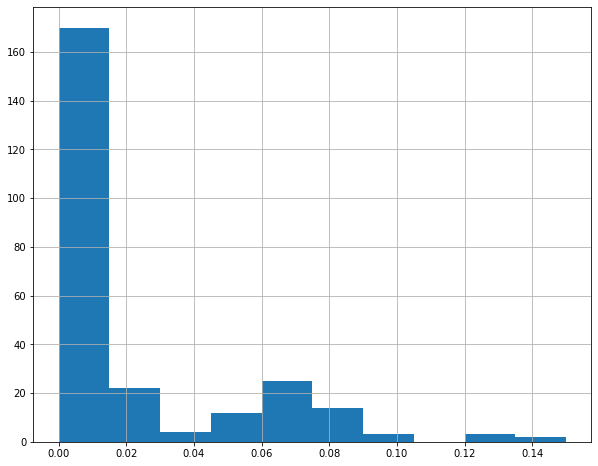

In [17]:
df['floor_price'].hist()

<AxesSubplot:>

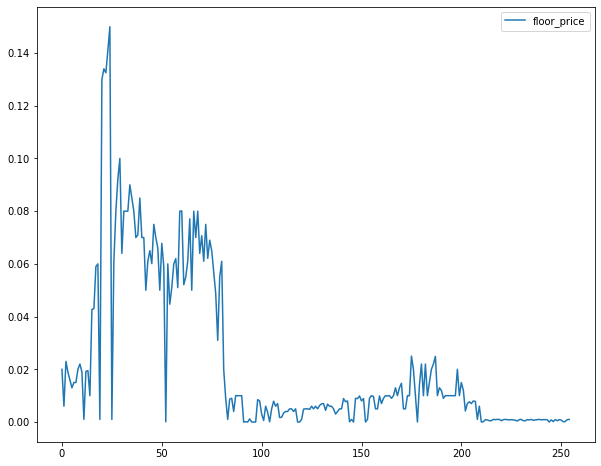

In [18]:
df[['floor_price']].plot(kind='line')

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

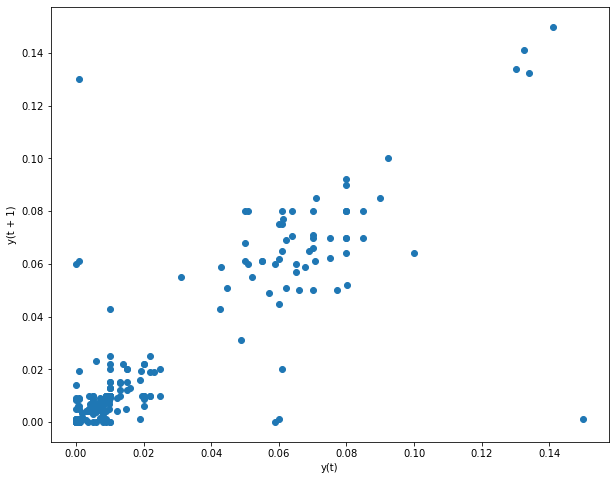

In [19]:
pd.plotting.lag_plot(df['floor_price'],lag=1)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 7)'>

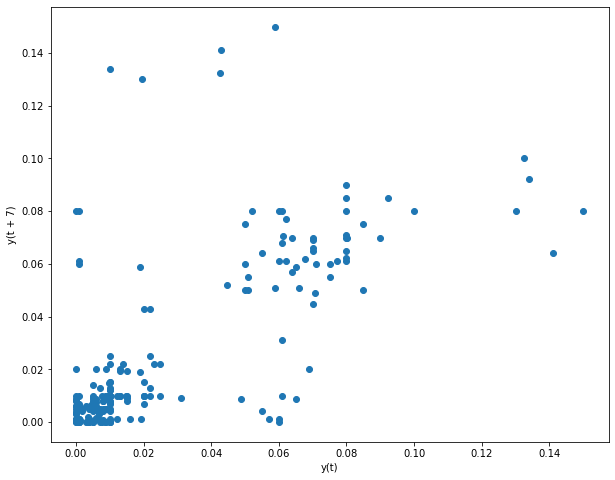

In [20]:
pd.plotting.lag_plot(df['floor_price'],lag=7)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 30)'>

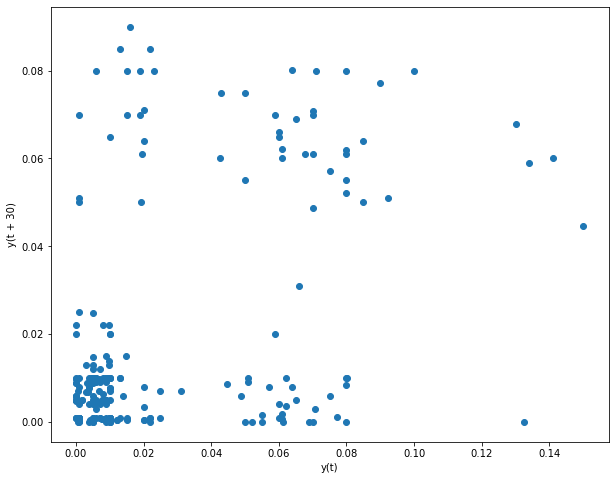

In [21]:
pd.plotting.lag_plot(df['floor_price'],lag=30)

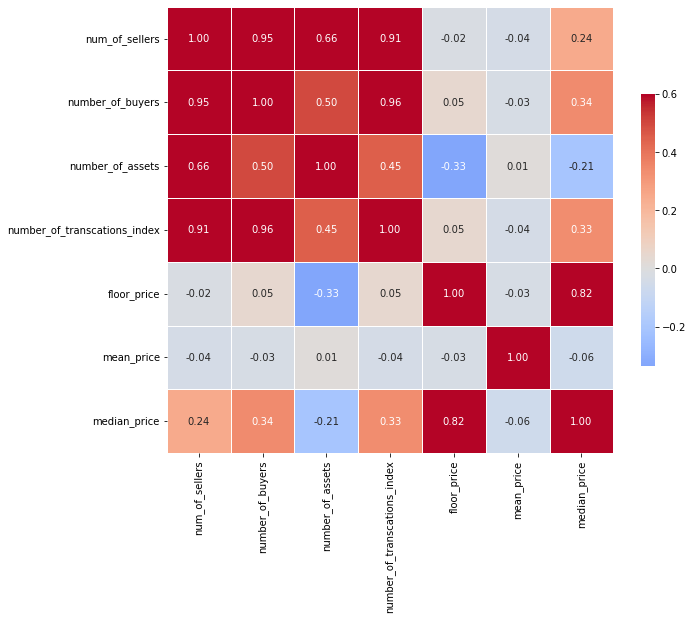

In [22]:
g = sns.heatmap(corr_matrix,  vmax=.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.figure.set_size_inches(10,10)
    
plt.show()

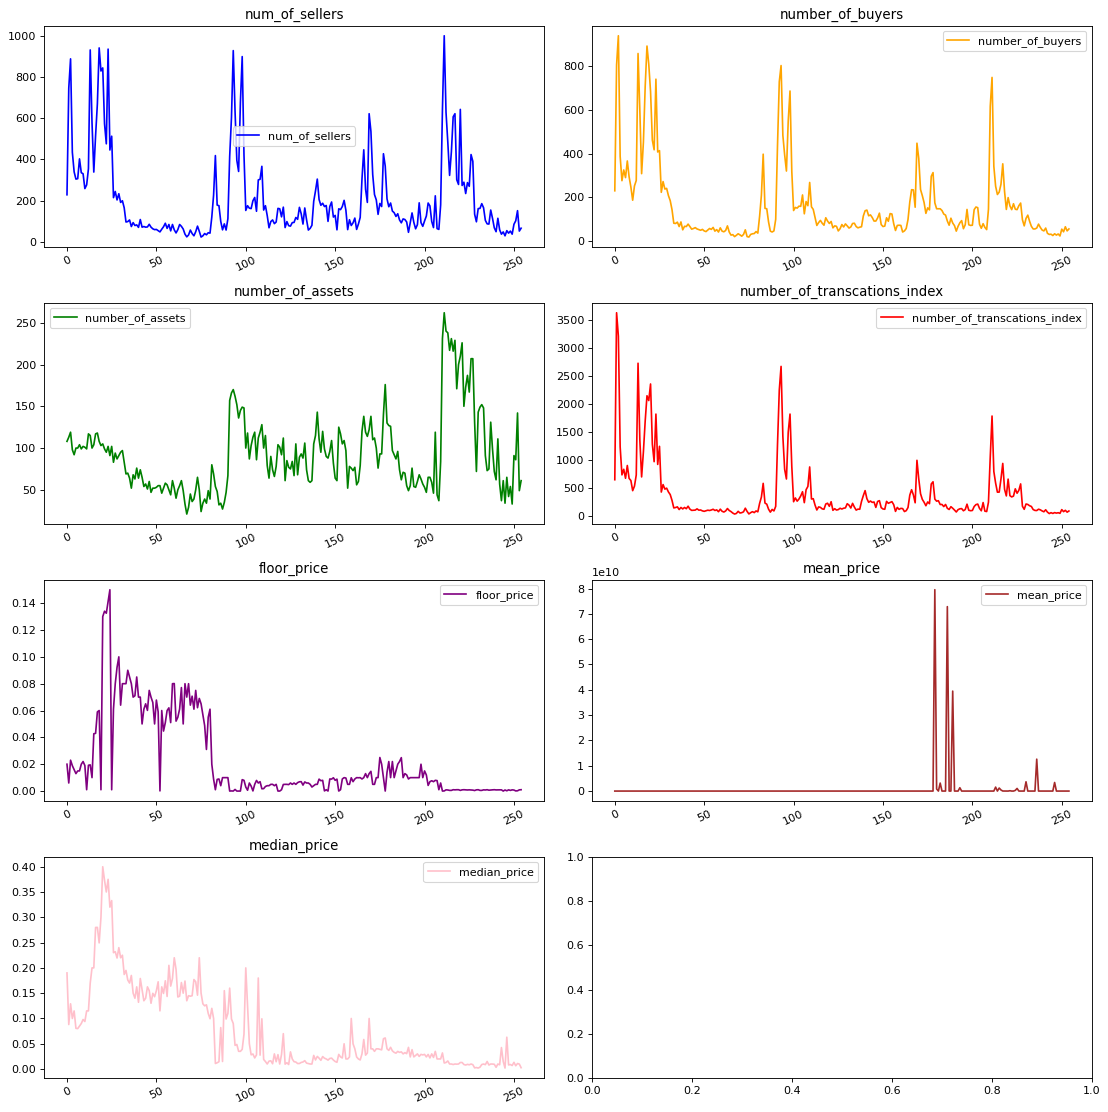

In [23]:
color_list = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]


def Visualize(data):
    features= list(df.select_dtypes(include=[np.number]).columns.values)
    feature_size=len(features)
    fig, axes = plt.subplots(
        nrows=int(np.ceil(feature_size/2)), ncols=2, figsize=(14, feature_size*2), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(feature_size):
        key = features[i]
        c = color_list[i % (len(color_list))]
        t_data = data[key]
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(key),
            rot=25,
        )
        ax.legend([key])
    plt.tight_layout()


Visualize(df)

In [24]:
result = adfuller(df["floor_price"])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critial Values: {result[4]}')

if result[1] > 0.05 :
  print('Series is not Stationary')
else:
  print('Series is Stationary')

Test Statistics: -1.5440012094160271
p-value: 0.5116432597109977
Critial Values: {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}
Series is not Stationary


In [25]:
df['floor_price']

0      0.02000
1      0.00600
2      0.02300
3      0.01890
4      0.01600
        ...   
250    0.00075
251    0.00010
252    0.00020
253    0.00090
254    0.00100
Name: floor_price, Length: 255, dtype: float64

In [26]:
df["floor_price"].diff(periods=1)

0          NaN
1     -0.01400
2      0.01700
3     -0.00410
4     -0.00290
        ...   
250   -0.00015
251   -0.00065
252    0.00010
253    0.00070
254    0.00010
Name: floor_price, Length: 255, dtype: float64

In [27]:
result = adfuller(df["floor_price"].diff(periods=1).dropna())
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critial Values: {result[4]}')

if result[1] > 0.05 :
  print('Series is not Stationary')
else:
  print('Series is Stationary')

Test Statistics: -11.239182938539335
p-value: 1.825070981957416e-20
Critial Values: {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}
Series is Stationary


In [28]:
df['floor_price']=df['floor_price'].diff(periods=1).fillna(method='bfill')

In [29]:
df.head()

,date,collectionname,num_of_sellers,number_of_buyers,number_of_assets,number_of_transcations_index,floor_price,mean_price,median_price
0,2021-08-01,Parallel Alpha,228,230,108,641,-0.0140,31.648996,0.1900
1,2021-08-02,Parallel Alpha,745,804,113,3632,-0.0140,15.646073,0.0880
2,2021-08-03,Parallel Alpha,887,937,119,3212,0.0170,1.429123,0.1290
3,2021-08-04,Parallel Alpha,434,387,98,1230,-0.0041,66.104642,0.1000
4,2021-08-05,Parallel Alpha,339,276,92,728,-0.0029,3.271091,0.1149


In [30]:
df['date'].min(),df['date'].max()

(Timestamp('2021-08-01 00:00:00'), Timestamp('2022-04-12 00:00:00'))

In [31]:
#split data into train and test sets
split_date ='2022-03-01'
df_train = df.loc[df.date <= split_date].copy()
df_test = df.loc[df.date > split_date].copy()

In [32]:
len(df_train), len(df_test)

(213, 42)

In [33]:
def create_features(df, label=None):
    """
    Creates features from column index
    """
    
    X = df[['num_of_sellers','number_of_buyers','number_of_assets','number_of_transcations_index','mean_price','median_price']]
    #The features: TSI,humidity,wind_speed,clouds_all have been removed
    #We would like to reintegrate these into the model, however they are generating bad forecasts
    #The final model should be:
    #X = df[['az','el','temp','tsi','humidity','wind_speed','clouds_all']]
    if label:
        y = df[label]
        return X, y
    return X

In [34]:
#Split train and test sets into X (features) and y - (label)
X_train, y_train = create_features(df_train, label='floor_price')
X_test, y_test = create_features(df_test, label='floor_price')

In [35]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [36]:
#Scale the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
param_grid = { 
    'n_estimators': [100,500],
    'max_depth': [3,5],
    'learning_rate' : [0.01,0.1]
}
reg = xgb.XGBRegressor(random_state=0,verbose=0)
cv_xgb = GridSearchCV(estimator=reg, param_grid=param_grid, cv=5,verbose=0)

cv_xgb.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)
yhat = cv_xgb.best_estimator_.predict(X_test)

[18:16:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:16:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:16:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.


[18:16:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:16:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:16:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.


In [38]:
cv_xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

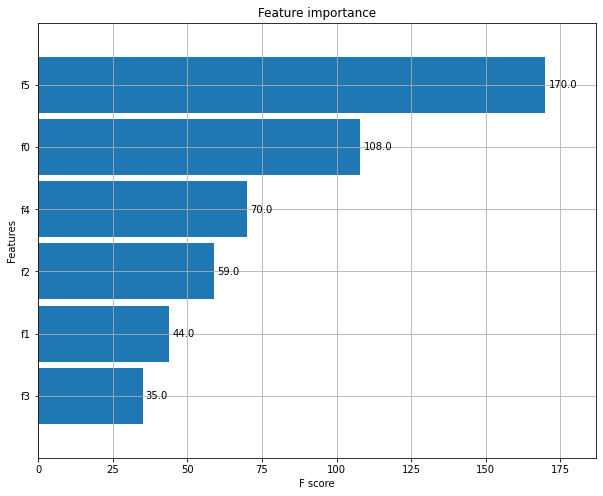

In [39]:
#Plot feature importance
_ = plot_importance(cv_xgb.best_estimator_, height=0.9)

In [40]:
#score the model
mae = mean_absolute_error(yhat,y_test)
print("MAE:", mae)

MAE: 0.0020429232064260875


In [41]:
#score the model
rmse = np.sqrt(mean_squared_error(yhat,y_test))
print("RMSE:", rmse)

RMSE: 0.0030305343378582905


In [42]:
#score the model
score = cv_xgb.best_estimator_.score(X_test,y_test) 
print("Training score: ", score)

Training score:  -70.24192121939136


In [43]:
import scipy

In [44]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(yhat, y_test)
'Pvalue:',p_value,'Rvalue:',r_value

('Pvalue:', 0.0048582234987690435, 'Rvalue:', 0.4264662256253074)

/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='floor_price'>

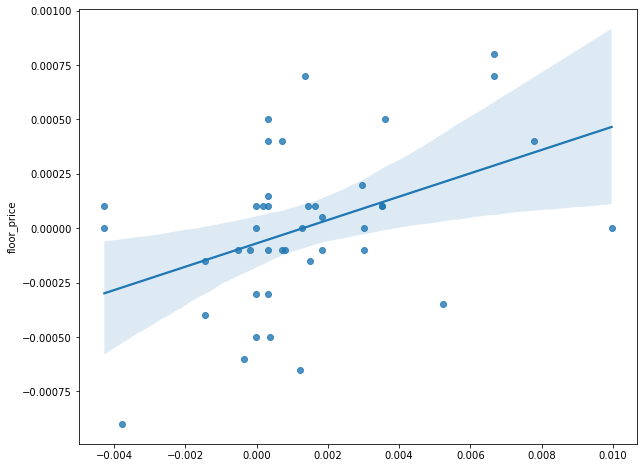

In [45]:
sns.regplot(yhat, y_test)

### Prophet

In [46]:
df.head(2)

,date,collectionname,num_of_sellers,number_of_buyers,number_of_assets,number_of_transcations_index,floor_price,mean_price,median_price
0,2021-08-01,Parallel Alpha,228,230,108,641,-0.014,31.648996,0.190
1,2021-08-02,Parallel Alpha,745,804,113,3632,-0.014,15.646073,0.088


In [47]:
df_prophet=df.reset_index()[['date','floor_price','median_price','num_of_sellers','number_of_buyers','number_of_assets',
                             'number_of_transcations_index','mean_price']].rename({'date':'ds','floor_price':'y'}, axis='columns')

In [48]:
df_prophet.head(2)

,ds,y,median_price,num_of_sellers,number_of_buyers,number_of_assets,number_of_transcations_index,mean_price
0,2021-08-01,-0.014,0.190,228,230,108,641,31.648996
1,2021-08-02,-0.014,0.088,745,804,113,3632,15.646073


In [49]:
df['date'].min()

Timestamp('2021-08-01 00:00:00')

In [50]:
train=df_prophet[(df_prophet['ds'] >= '2021-08-01') & (df_prophet['ds'] <= '2022-03-01')]
test=df_prophet[(df_prophet['ds'] > '2022-03-01')]

In [51]:
m = Prophet(interval_width=0.95,yearly_seasonality=True)

In [52]:
#m.add_regressor('num_of_sellers',standardize=False)
#m.add_regressor('number_of_buyers',standardize=False)
#m.add_regressor('number_of_assets',standardize=False)
#m.add_regressor('number_of_transcations_index',standardize=False)
#m.add_regressor('mean_price',standardize=False)
#m.add_regressor('median_price',standardize=False)

In [53]:
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.89629


/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      36       343.199   3.27296e-05       101.234   3.388e-07       0.001       90  LS failed, Hessian reset 
      72       343.201   1.64454e-08        96.949      0.7525      0.7525      134   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [54]:
future = m.make_future_dataframe(periods=7)
future.tail()

,ds
215,2022-03-04
216,2022-03-05
217,2022-03-06
218,2022-03-07
219,2022-03-08


In [55]:
future['y'] = df_prophet['y']

In [56]:
future

,ds,y
0,2021-08-01,-0.0140
1,2021-08-02,-0.0140
2,2021-08-03,0.0170
3,2021-08-04,-0.0041
4,2021-08-05,-0.0029
...,...,...
215,2022-03-04,0.0000
216,2022-03-05,0.0005
217,2022-03-06,-0.0001
218,2022-03-07,0.0001


In [57]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
215,2022-03-04,-0.000668,-0.036805,0.031751
216,2022-03-05,0.004540,-0.031644,0.039622
217,2022-03-06,0.002489,-0.031435,0.041734
218,2022-03-07,0.003412,-0.033668,0.038397
219,2022-03-08,0.001496,-0.031401,0.036865


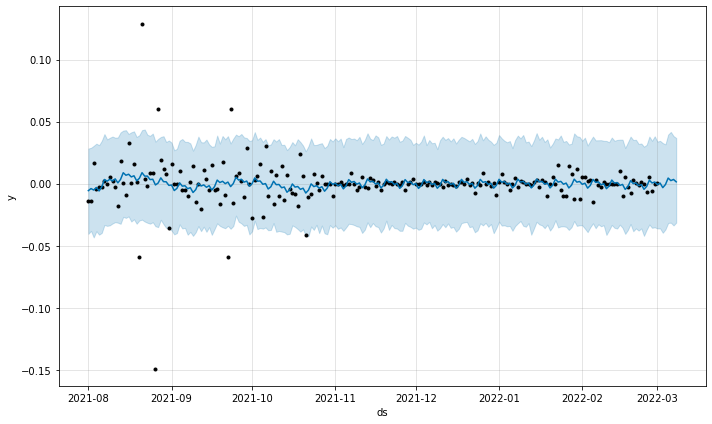

In [58]:
fig1 =m.plot(forecast)

/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


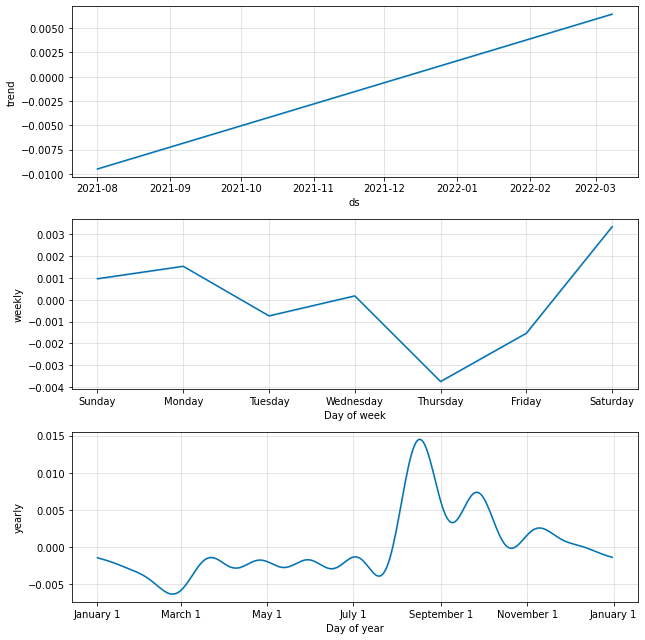

In [59]:
fig2 = m.plot_components(forecast)

In [60]:
len(test)

42

In [61]:
from fbprophet.diagnostics import cross_validation,  performance_metrics
cv_results = cross_validation( model = m, initial = '100 days', horizon = '2 days')
df_p = performance_metrics(cv_results)
df_p

INFO:fbprophet:Making 111 forecasts with cutoffs between 2021-11-09 00:00:00 and 2022-02-27 00:00:00
  0%|                                                   | 0/111 [00:00<?, ?it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(n

Initial log joint probability = -3.7642
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       128.429   7.95095e-09       100.722      0.2356      0.2356       73   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


  1%|▍                                          | 1/111 [00:00<00:44,  2.49it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.729
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       130.179   2.19763e-06       100.168      0.5694      0.5694      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123        130.18   5.24944e-09       100.315      0.1971      0.1971      156   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


  2%|▊                                          | 2/111 [00:00<00:42,  2.55it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.68119
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       131.812   0.000131351       101.605   1.344e-06       0.001      119  LS failed, Hessian reset 
      91       131.834   5.58711e-05       101.277   5.536e-07       0.001      196  LS failed, Hessian reset 
      99       131.837   2.69456e-06       99.0887      0.6836      0.6836      207   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       131.838   7.12574e-09       99.0313       0.189       0.189      232   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


  3%|█▏                                         | 3/111 [00:01<00:44,  2.45it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.73194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       133.596   5.30242e-07       104.946   5.394e-09       0.001      123  LS failed, Hessian reset 
      80       133.596   8.95243e-09       100.769           1           1      140   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


  4%|█▌                                         | 4/111 [00:01<00:42,  2.53it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.75091
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57       135.248   9.35057e-09       100.002      0.5602      0.5602       79   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


  5%|█▉                                         | 5/111 [00:01<00:41,  2.57it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.68511
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       136.996   7.40876e-09       98.4828      0.4205      0.4205      102   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


  5%|██▎                                        | 6/111 [00:02<00:40,  2.61it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.6916
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       138.802    1.6996e-05       100.502      0.3902      0.8656      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       138.804   5.03771e-09       100.352       0.273       0.273      190   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


  6%|██▋                                        | 7/111 [00:02<00:41,  2.51it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.7343
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       140.584   9.24519e-09        94.281      0.5022      0.5022       93   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


  7%|███                                        | 8/111 [00:03<00:40,  2.54it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.70592
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       142.406    5.3282e-09       99.2308      0.4859      0.4859      106   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


  8%|███▍                                       | 9/111 [00:03<00:40,  2.54it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.79017
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54        144.22   4.42964e-09       99.4319      0.2058      0.2058       72   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


  9%|███▊                                      | 10/111 [00:03<00:40,  2.47it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.71685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56        146.02   9.72427e-08       99.3963   9.973e-10       0.001      126  LS failed, Hessian reset 
      62        146.02   2.13158e-09        99.316      0.1625      0.1625      135   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 10%|████▏                                     | 11/111 [00:04<00:39,  2.52it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.70556
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       147.793   8.30357e-09       105.302      0.6263      0.6263      124   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 11%|████▌                                     | 12/111 [00:04<00:38,  2.56it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.71467
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       149.625   1.30273e-06       99.0778   1.291e-08       0.001      142  LS failed, Hessian reset 
      95       149.625   8.04176e-09        98.953      0.3265      0.3265      167   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 12%|████▉                                     | 13/111 [00:05<00:39,  2.49it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.72159
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       151.421   6.75824e-08        103.62   6.971e-10       0.001      138  LS failed, Hessian reset 
      73       151.421   2.28098e-09       97.6771      0.1962      0.1962      142   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 13%|█████▎                                    | 14/111 [00:05<00:38,  2.53it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.71349
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       153.248   4.26075e-05       104.181   4.511e-07       0.001      122  LS failed, Hessian reset 
      99       153.255   1.02176e-07       98.4569       0.274           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       153.255    9.3252e-10       101.145     0.05868     0.05868      207   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 14%|█████▋                                    | 15/111 [00:05<00:37,  2.57it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.72413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61        155.08   0.000149938       100.013   1.496e-06       0.001      122  LS failed, Hessian reset 
      99       155.097   4.01421e-08       101.159      0.7101      0.7101      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       155.097   8.12777e-09       99.5575      0.2996      0.2996      179   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 14%|██████                                    | 16/111 [00:06<00:38,  2.50it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.73673
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       156.896   9.92588e-09       99.5793      0.2578      0.2578       80   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 15%|██████▍                                   | 17/111 [00:06<00:36,  2.55it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.71699
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       158.743   4.20351e-09       100.284     0.08698      0.5511       83   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 16%|██████▊                                   | 18/111 [00:07<00:36,  2.57it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.80326
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      52       160.427   7.19721e-09       100.453      0.4433      0.4433       68   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 17%|███████▏                                  | 19/111 [00:07<00:36,  2.51it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.72989
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       162.261   0.000342848        99.284    3.43e-06       0.001      116  LS failed, Hessian reset 
      92       162.281   5.74743e-09       99.8511      0.1879      0.1879      161   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 18%|███████▌                                  | 20/111 [00:07<00:35,  2.55it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.72119
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       164.127   6.98985e-05       100.544   7.211e-07       0.001      131  LS failed, Hessian reset 
      99       164.134   4.26667e-07       96.4519       3.022     0.03022      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       164.134   5.70432e-07       103.799   5.829e-09       0.001      250  LS failed, Hessian reset 
     140       164.134    8.7109e-09       97.4049      0.2379           1      289   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 19%|███████▉                                  | 21/111 [00:08<00:35,  2.57it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.70347
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       165.964   8.60407e-08        100.14      0.9691      0.9691      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       165.964   3.03031e-09       100.012        0.15        0.15      136   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 20%|████████▎                                 | 22/111 [00:08<00:34,  2.60it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.73284
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57       167.813   4.21523e-06       101.524    4.21e-08       0.001      114  LS failed, Hessian reset 
      73       167.813   5.36855e-09        97.044       0.312       0.312      137   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 21%|████████▋                                 | 23/111 [00:09<00:34,  2.53it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.73524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       169.623   8.64173e-09       100.547      0.4507      0.4507       91   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 22%|█████████                                 | 24/111 [00:09<00:33,  2.58it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.73886
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       171.515   8.95911e-09       98.7338      0.3518      0.3518       79   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 23%|█████████▍                                | 25/111 [00:09<00:34,  2.52it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.72531
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       173.293   9.84056e-09       96.2772      0.3656      0.3656       79   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 23%|█████████▊                                | 26/111 [00:10<00:33,  2.57it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.75182
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62        175.22   3.46824e-06       100.014   3.508e-08       0.001      125  LS failed, Hessian reset 
      80       175.221   8.03635e-09       100.656      0.2345      0.2345      150   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 24%|██████████▏                               | 27/111 [00:10<00:32,  2.59it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.72964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       177.091   1.03646e-06       97.2199   1.038e-08       0.001      130  LS failed, Hessian reset 
      99       177.091   5.54022e-08       98.6026           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       177.091   9.31646e-09       103.048      0.4948      0.4948      174   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 25%|██████████▌                               | 28/111 [00:11<00:33,  2.51it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.75472
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       178.982   3.97374e-09       101.191      0.2242      0.2242       78   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 26%|██████████▉                               | 29/111 [00:11<00:32,  2.55it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.72933
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       180.862   5.83172e-05       100.644   5.764e-07       0.001      140  LS failed, Hessian reset 
      99       180.872   7.77592e-07       97.5029      0.6492      0.6492      192   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       180.873   1.57791e-06       98.2007   1.553e-08       0.001      277  LS failed, Hessian reset 
     157       180.873   3.21095e-09       98.6413      0.1269      0.1269      309   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 27%|███████████▎                              | 30/111 [00:11<00:31,  2.57it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.73731
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       182.709   9.10965e-09       98.3187      0.2518      0.2518       76   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 28%|███████████▋                              | 31/111 [00:12<00:30,  2.59it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.7446
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      38       184.622   6.35443e-05       100.359   6.279e-07       0.001       98  LS failed, Hessian reset 
      88       184.629   6.08989e-09       99.4913      0.2412      0.2412      166   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 29%|████████████                              | 32/111 [00:12<00:31,  2.52it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.78547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       186.397   9.55101e-09       98.1096      0.1401      0.1401       76   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 30%|████████████▍                             | 33/111 [00:12<00:30,  2.57it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.72479
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       188.306   4.41743e-05        101.67   4.486e-07       0.001      119  LS failed, Hessian reset 
      99       188.309   2.48338e-08       101.366       0.521       0.521      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       188.309   7.69867e-07       100.471   7.542e-09       0.001      212  LS failed, Hessian reset 
     131        188.31   3.83758e-09       99.6305      0.1592      0.1592      245   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 31%|████████████▊                             | 34/111 [00:13<00:29,  2.58it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.7607
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66        190.19   6.09777e-09       104.594      0.5657      0.5657       89   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 32%|█████████████▏                            | 35/111 [00:13<00:30,  2.52it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.7514
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       192.102   1.80933e-07       98.3784   1.789e-09       0.001      126  LS failed, Hessian reset 
      93       192.102   6.65144e-09       97.5037      0.4718      0.4718      160   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 32%|█████████████▌                            | 36/111 [00:14<00:29,  2.56it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.76662
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       194.009   5.51151e-09       95.4388      0.4415      0.4415       94   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 33%|██████████████                            | 37/111 [00:14<00:28,  2.60it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.78404
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       195.913   5.25022e-09        97.873      0.5364      0.5364      109   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 34%|██████████████▍                           | 38/111 [00:14<00:28,  2.53it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.74354
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76        197.83   4.17681e-06        100.74   4.168e-08       0.001      139  LS failed, Hessian reset 
      99        197.83   2.40882e-06       100.442           1           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       197.831    7.5925e-07       99.7279   7.559e-09       0.001      208  LS failed, Hessian reset 
     113       197.831   9.99484e-09        100.48      0.5598      0.5598      224   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 35%|██████████████▊                           | 39/111 [00:15<00:28,  2.56it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.74473
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       199.717   6.56132e-09       99.8642     0.07599     0.07599       74   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 36%|███████████████▏                          | 40/111 [00:15<00:27,  2.59it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.75818
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       201.646   6.71063e-09       99.0761      0.6925      0.6925      113   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 37%|███████████████▌                          | 41/111 [00:16<00:27,  2.53it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.72317
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       203.568   8.84845e-09       98.2961       0.543       0.543       86   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 38%|███████████████▉                          | 42/111 [00:16<00:26,  2.58it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.77917
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       205.505   3.47192e-09       101.834      0.2462      0.2462      106   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 39%|████████████████▎                         | 43/111 [00:16<00:26,  2.60it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.75856
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       207.449   7.17876e-09       99.3295      0.4912      0.4912       82   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 40%|████████████████▋                         | 44/111 [00:17<00:26,  2.54it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.94046
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       209.389   5.78069e-09        96.413      0.1625      0.1625       93   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 41%|█████████████████                         | 45/111 [00:17<00:25,  2.57it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.75526
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       211.318    0.00010449       99.7437   1.046e-06       0.001      134  LS failed, Hessian reset 
      99       211.328    9.1302e-09       98.6698      0.1782           1      184   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 41%|█████████████████▍                        | 46/111 [00:18<00:24,  2.60it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.78274
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      51       213.217   4.54604e-09       103.149      0.2086      0.2086       68   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 42%|█████████████████▊                        | 47/111 [00:18<00:25,  2.53it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.733
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       215.066   6.03582e-09       95.8957      0.5944      0.5944       86   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 43%|██████████████████▏                       | 48/111 [00:18<00:24,  2.58it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.77399
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       217.014   8.64255e-05       98.6414   8.704e-07       0.001      111  LS failed, Hessian reset 
      99       217.022   4.39438e-08       100.457      0.7858      0.7858      152   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       217.022   1.57367e-07       99.6521   1.583e-09       0.001      197  LS failed, Hessian reset 
     110       217.022   6.50902e-09       98.1903      0.3041      0.3041      204   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 44%|██████████████████▌                       | 49/111 [00:19<00:23,  2.59it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.76052
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       218.969    1.1223e-06       100.567   1.119e-08       0.001      154  LS failed, Hessian reset 
      99        218.97   6.17744e-08       101.038      0.6899      0.6899      191   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107        218.97   5.32437e-09       100.222      0.6383      0.6383      202   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 45%|██████████████████▉                       | 50/111 [00:19<00:23,  2.60it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.80717
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       220.917   3.28227e-09       100.841      0.2864      0.2864       91   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 46%|███████████████████▎                      | 51/111 [00:19<00:23,  2.53it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.76444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70        222.84   4.89836e-07       99.0638   4.999e-09       0.001      129  LS failed, Hessian reset 
      82        222.84   7.16178e-09        101.24      0.3773      0.3773      144   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 47%|███████████████████▋                      | 52/111 [00:20<00:22,  2.58it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.99939
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       224.727   9.70987e-09       92.9594      0.2811      0.2811       81   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 48%|████████████████████                      | 53/111 [00:20<00:22,  2.58it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.76795
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       226.692   4.91508e-06       100.432   4.899e-08       0.001      120  LS failed, Hessian reset 
      76       226.692   9.13293e-09       99.8269           1           1      149   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 49%|████████████████████▍                     | 54/111 [00:21<00:22,  2.51it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.73825
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59        228.58   3.92436e-09        97.762      0.1534      0.1534       77   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 50%|████████████████████▊                     | 55/111 [00:21<00:21,  2.56it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.77139
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       230.564    8.5811e-09       98.6475       0.304           1       72   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 50%|█████████████████████▏                    | 56/111 [00:21<00:21,  2.59it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.79152
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       232.542   9.50952e-09       99.1573      0.4008      0.4008       93   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 51%|█████████████████████▌                    | 57/111 [00:22<00:21,  2.52it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.88656
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85        234.48   4.58627e-09       92.8416      0.5859      0.5859      108   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 52%|█████████████████████▉                    | 58/111 [00:22<00:20,  2.56it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.79006
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       236.424   2.63506e-05       97.2254   2.628e-07       0.001      141  LS failed, Hessian reset 
      99       236.427   5.48112e-07       97.2756      0.3087           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       236.431   5.32704e-09       99.2725      0.2452      0.2452      231   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 53%|██████████████████████▎                   | 59/111 [00:23<00:20,  2.58it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.74412
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        238.39   1.34608e-05        100.11       0.273       0.273      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       238.391   2.96881e-09       100.016      0.2903      0.2903      176   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 54%|██████████████████████▋                   | 60/111 [00:23<00:20,  2.51it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.84913
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       240.253   6.87417e-07       100.717      0.4039           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       240.253   9.68567e-07         100.7   9.674e-09       0.001      183  LS failed, Hessian reset 
     130       240.253   7.77727e-09       99.7303      0.2726      0.2726      202   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 55%|███████████████████████                   | 61/111 [00:23<00:19,  2.54it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.76817
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       242.235   5.34229e-09        100.11      0.5303      0.5303       71   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 56%|███████████████████████▍                  | 62/111 [00:24<00:18,  2.59it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.78161
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       244.202   6.47919e-09       101.057      0.3041           1       79   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 57%|███████████████████████▊                  | 63/111 [00:24<00:19,  2.52it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.79941
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       246.235   1.55233e-05       99.8628           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       246.238   7.49794e-06       100.255   7.489e-08       0.001      203  LS failed, Hessian reset 
     152        246.24   6.18041e-09       100.138      0.3408      0.3408      248   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 58%|████████████████████████▏                 | 64/111 [00:25<00:18,  2.53it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.79756
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       248.225   8.20481e-09       100.818      0.2384      0.2384       85   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 59%|████████████████████████▌                 | 65/111 [00:25<00:18,  2.55it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.81813
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       250.225    4.0502e-09        99.664      0.2937      0.2937       83   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 59%|████████████████████████▉                 | 66/111 [00:25<00:18,  2.49it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.78679
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      42       252.225   3.97915e-05       99.2736   4.129e-07       0.001       91  LS failed, Hessian reset 
      89        252.23   5.10222e-06       101.723   4.971e-08       0.001      186  LS failed, Hessian reset 
      99        252.23   1.60258e-06       98.4222      0.9839      0.9839      198   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       252.231    2.1161e-07       101.768   2.127e-09       0.001      279  LS failed, Hessian reset 
     143       252.231   9.81745e-09       102.845      0.3932      0.3932      291   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 60%|█████████████████████████▎                | 67/111 [00:26<00:17,  2.52it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.76487
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      50       254.212   6.05749e-09       100.118      0.1987      0.1987       65   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 61%|█████████████████████████▋                | 68/111 [00:26<00:17,  2.53it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.86668
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       256.221   4.93993e-06       102.967   5.009e-08       0.001      110  LS failed, Hessian reset 
      78       256.221   6.49095e-07       98.0686   6.466e-09       0.001      175  LS failed, Hessian reset 
      99       256.222   2.77452e-07       103.336           1           1      202   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       256.224    7.0519e-09       97.3573      0.4377      0.4377      280   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 62%|██████████████████████████                | 69/111 [00:27<00:16,  2.55it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.76754
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       258.234   5.13119e-09       100.344       0.514       0.514       85   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 63%|██████████████████████████▍               | 70/111 [00:27<00:16,  2.51it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.78289
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       260.252   4.29046e-06       101.377   4.359e-08       0.001      120  LS failed, Hessian reset 
      79       260.252   5.28918e-09       97.4071      0.2007      0.2007      145   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 64%|██████████████████████████▊               | 71/111 [00:27<00:15,  2.56it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -4.09651
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       262.156    4.8498e-09        100.77      0.1576      0.4623       81   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 65%|███████████████████████████▏              | 72/111 [00:28<00:15,  2.59it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.81316
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       264.102   0.000102517       100.186   1.014e-06       0.001      129  LS failed, Hessian reset 
      88       264.117   3.09652e-09       99.9737      0.2232      0.2232      175   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 66%|███████████████████████████▌              | 73/111 [00:28<00:15,  2.52it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.76172
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       266.092   7.26008e-09        94.339      0.2343      0.2343       91   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 67%|████████████████████████████              | 74/111 [00:29<00:14,  2.54it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.8165
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      48        268.07   6.66723e-09       100.633      0.2446      0.2446       66   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 68%|████████████████████████████▍             | 75/111 [00:29<00:14,  2.55it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.84939
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       269.886   9.83965e-09       101.199      0.4358      0.4358       83   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 68%|████████████████████████████▊             | 76/111 [00:29<00:14,  2.47it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
 69%|█████████████████████████████▏            | 77/111 [00:30<00:13,  2.52it/s]

Initial log joint probability = -3.94839
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       271.791   4.96023e-05       98.1325   5.015e-07       0.001      124  LS failed, Hessian reset 
      99       271.796   7.18774e-07       100.429       0.455           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       271.796   8.66423e-09       101.373      0.5164      0.5164      208   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -4.13938
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       273.737   7.61356e-09       98.5205       0.409       0.409       93   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 70%|█████████████████████████████▌            | 78/111 [00:30<00:12,  2.54it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -4.13998
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       275.689   8.02173e-09       102.974      0.4273           1       87   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 71%|█████████████████████████████▉            | 79/111 [00:31<00:12,  2.47it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.85069
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64        277.19    1.5266e-07       101.503   1.516e-09       0.001      118  LS failed, Hessian reset 
      72        277.19   9.78126e-09       97.4692      0.4311      0.4311      128   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 72%|██████████████████████████████▎           | 80/111 [00:31<00:12,  2.52it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.7799
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       279.179   5.58738e-08       99.5355      0.1837           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       279.179   6.25076e-09       94.4545      0.3067           1      148   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 73%|██████████████████████████████▋           | 81/111 [00:31<00:11,  2.56it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -4.26031
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       280.759   6.35656e-05       101.147   6.465e-07       0.001      145  LS failed, Hessian reset 
      99       280.765   1.36008e-06       98.8304      0.2937           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       280.765    8.4152e-09       99.4158      0.2032      0.2032      198   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 74%|███████████████████████████████           | 82/111 [00:32<00:11,  2.48it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.82371
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       282.649   6.13248e-09       99.5605      0.4014      0.4014       83   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 75%|███████████████████████████████▍          | 83/111 [00:32<00:11,  2.54it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -4.27441
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65        284.43   7.03879e-09       98.8147      0.2204      0.2204       86   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 76%|███████████████████████████████▊          | 84/111 [00:32<00:10,  2.58it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.79848
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       286.399   9.77987e-09       90.3238      0.3665           1       89   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 77%|████████████████████████████████▏         | 85/111 [00:33<00:10,  2.51it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.79899
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       288.441   4.12799e-06       102.642   4.144e-08       0.001      137  LS failed, Hessian reset 
      98       288.441   4.99197e-09       93.1064      0.2013      0.2013      166   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 77%|████████████████████████████████▌         | 86/111 [00:33<00:09,  2.52it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.8277
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      40       290.431    0.00033852       94.2595   2.966e-06       0.001       94  LS failed, Hessian reset 
      92       290.468    9.6789e-09       101.093      0.4275      0.4275      156   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 78%|████████████████████████████████▉         | 87/111 [00:34<00:09,  2.53it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.81766
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       292.522   9.38125e-09       100.097      0.2483           1      111   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 79%|█████████████████████████████████▎        | 88/111 [00:34<00:09,  2.54it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -4.46561
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       294.033   1.49314e-08       99.6258      0.1872           1       94   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 80%|█████████████████████████████████▋        | 89/111 [00:35<00:08,  2.45it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.82571
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       296.048   9.85848e-09       100.533      0.4263      0.4263       71   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 81%|██████████████████████████████████        | 90/111 [00:35<00:08,  2.49it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.8922
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       298.124    4.9691e-09       98.1829      0.3921      0.3921       93   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 82%|██████████████████████████████████▍       | 91/111 [00:35<00:08,  2.45it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.94365
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      51       300.193   4.99638e-09       100.142      0.1258      0.1258       66   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 83%|██████████████████████████████████▊       | 92/111 [00:36<00:08,  2.36it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.85679
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       302.236    1.6114e-08       101.496      0.3148           1       80   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 84%|███████████████████████████████████▏      | 93/111 [00:36<00:07,  2.43it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.87604
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      40       304.286   1.92947e-05       99.7968   1.884e-07       0.001       89  LS failed, Hessian reset 
      64       304.287   3.86833e-09       100.444      0.1927      0.1927      121   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 85%|███████████████████████████████████▌      | 94/111 [00:37<00:06,  2.49it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.87745
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       306.359   1.42011e-08        100.83      0.2311           1       96   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 86%|███████████████████████████████████▉      | 95/111 [00:37<00:06,  2.41it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.87886
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       308.407    8.9227e-09       100.206      0.2114      0.2114      107   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 86%|████████████████████████████████████▎     | 96/111 [00:37<00:06,  2.45it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.88027
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       310.482   1.33424e-07       98.7614   1.331e-09       0.001      115  LS failed, Hessian reset 
      66       310.482   9.87025e-09       99.6177      0.3203      0.3203      122   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 87%|████████████████████████████████████▋     | 97/111 [00:38<00:05,  2.46it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.88169
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      49        312.56   4.35107e-06       101.429   4.315e-08       0.001      101  LS failed, Hessian reset 
      71        312.56    7.3308e-09       102.834      0.1911      0.4722      129   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 88%|█████████████████████████████████████     | 98/111 [00:38<00:05,  2.36it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.83115
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       314.502   6.25049e-09       97.3162      0.1873      0.1873       77   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 89%|█████████████████████████████████████▍    | 99/111 [00:39<00:04,  2.43it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -4.24028
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       316.393   6.98673e-05       97.3502   6.666e-07       0.001      129  LS failed, Hessian reset 
      99       316.401   8.71764e-09       97.2701      0.2233      0.2233      174   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 90%|████████████████████████████████████▉    | 100/111 [00:39<00:04,  2.35it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.82688
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       318.384   9.71206e-09       98.1177      0.2439      0.2439       76   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 91%|█████████████████████████████████████▎   | 101/111 [00:40<00:04,  2.34it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.96746
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70        320.45   5.20923e-07        100.43   5.252e-09       0.001      138  LS failed, Hessian reset 
      76        320.45   8.33708e-09        101.95      0.1166      0.1166      147   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 92%|█████████████████████████████████████▋   | 102/111 [00:40<00:03,  2.43it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -4.14544
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       322.345   7.83987e-09       100.118      0.2482           1       88   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 93%|██████████████████████████████████████   | 103/111 [00:40<00:03,  2.50it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.85205
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       324.433   7.29375e-08       100.082      0.4105           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       324.433   6.06922e-09       100.793      0.3358      0.3358      142   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 94%|██████████████████████████████████████▍  | 104/111 [00:41<00:02,  2.45it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.88484
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      52       326.524   3.05757e-09       99.1717      0.3009      0.3009       73   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 95%|██████████████████████████████████████▊  | 105/111 [00:41<00:02,  2.52it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.91503
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       328.612    6.0551e-09       99.5916      0.5901      0.5901       71   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 95%|███████████████████████████████████████▏ | 106/111 [00:41<00:01,  2.54it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.88211
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       330.715   7.77014e-09        102.87      0.3426           1       87   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 96%|███████████████████████████████████████▌ | 107/111 [00:42<00:01,  2.56it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.90693
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       332.796   0.000104605       97.1837    1.04e-06       0.001      109  LS failed, Hessian reset 
      95       332.805    6.7016e-09       97.4188      0.5333      0.5333      159   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 97%|███████████████████████████████████████▉ | 108/111 [00:42<00:01,  2.48it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -4.11828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       334.844   5.34183e-09       96.9701      0.2263      0.2263       88   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 98%|████████████████████████████████████████▎| 109/111 [00:43<00:00,  2.35it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -3.84175
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       336.951   5.01311e-09       96.5914      0.5057      0.5057       80   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 99%|████████████████████████████████████████▋| 110/111 [00:43<00:00,  2.36it/s]/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -4.09142
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      51       338.993   6.31373e-05       100.665     6.3e-07       0.001       95  LS failed, Hessian reset 
      99       338.998   2.05007e-07       100.196           1           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       338.999   2.73281e-06       100.021   2.715e-08       0.001      203  LS failed, Hessian reset 
     137           339   3.95147e-06       100.371   3.952e-08       0.001      290  LS failed, Hessian reset 
     161           339   9.21853e-09       100.264      0.2494      0.2494      322   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


100%|█████████████████████████████████████████| 111/111 [00:44<00:00,  2.51it/s]
INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,1 days,0.000056,0.007466,0.005609,2.167900,1.0
1,2 days,0.000049,0.007007,0.005061,1.863618,1.0


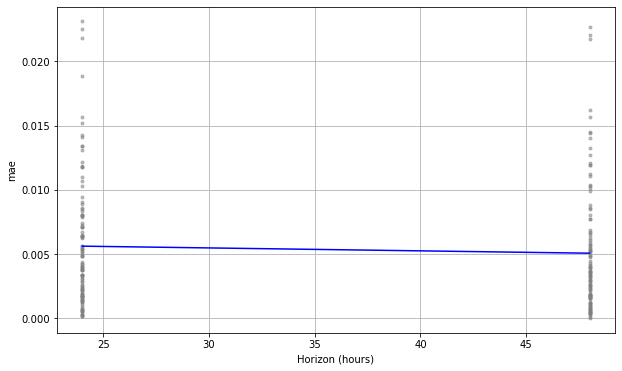

In [63]:
from fbprophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(cv_results, metric='mae')